<a href="https://colab.research.google.com/github/marzier/CSC481/blob/main/GA_v10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

===== INDOOR-LIKE ENVIRONMENT =====


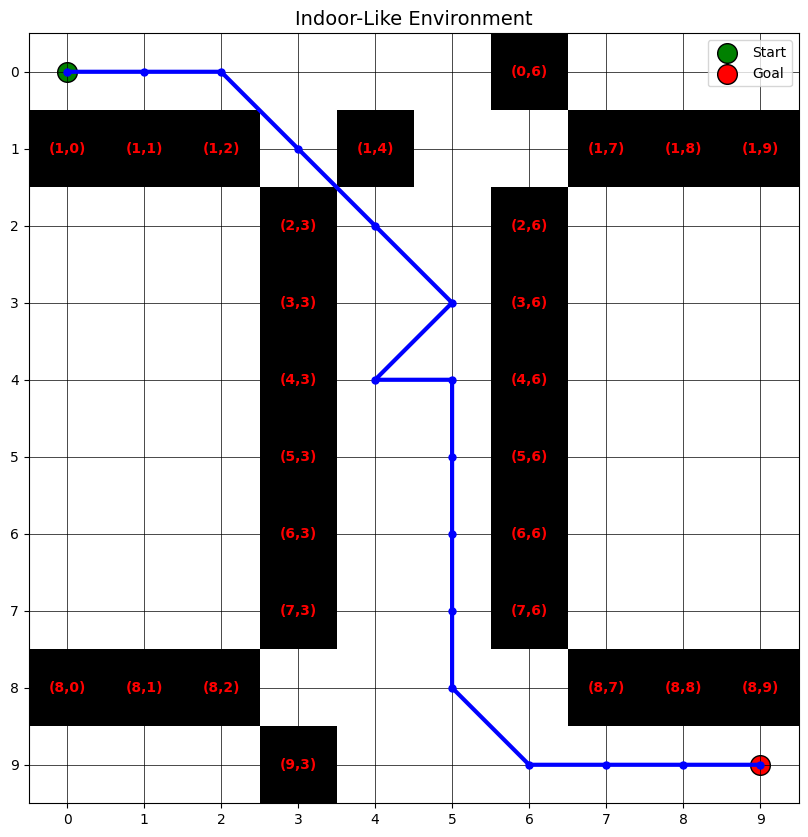

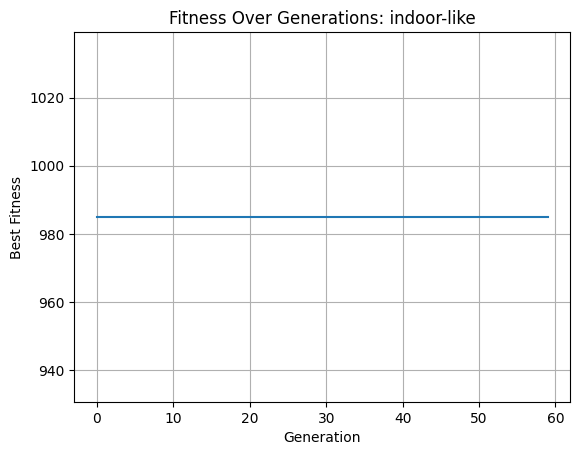

Best Path: [(0, 1), (0, 2), (1, 3), (2, 4), (3, 5), (4, 4), (4, 5), (5, 5), (6, 5), (7, 5), (8, 5), (9, 6), (9, 7), (9, 8), (9, 9)]
Obstacles: {(4, 3), (4, 6), (8, 0), (8, 9), (1, 0), (1, 9), (3, 3), (5, 6), (3, 6), (5, 3), (8, 2), (8, 8), (1, 2), (1, 8), (7, 3), (7, 6), (9, 3), (8, 1), (8, 7), (1, 1), (1, 4), (0, 6), (2, 3), (1, 7), (2, 6), (6, 6), (6, 3)}
Valid Path:
===== MODERATE SCATTERED ENVIRONMENT =====


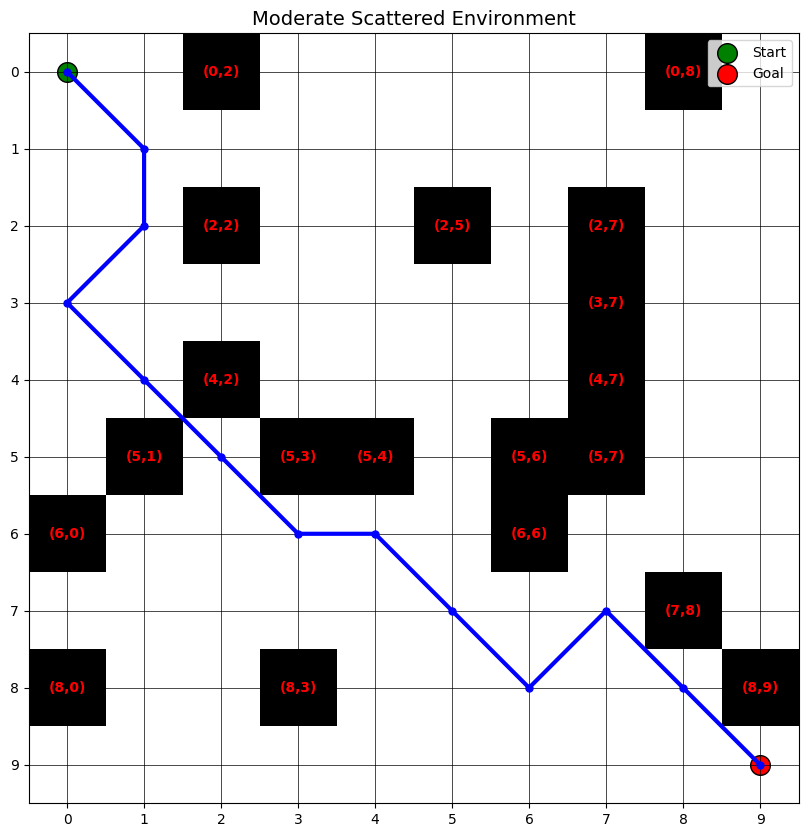

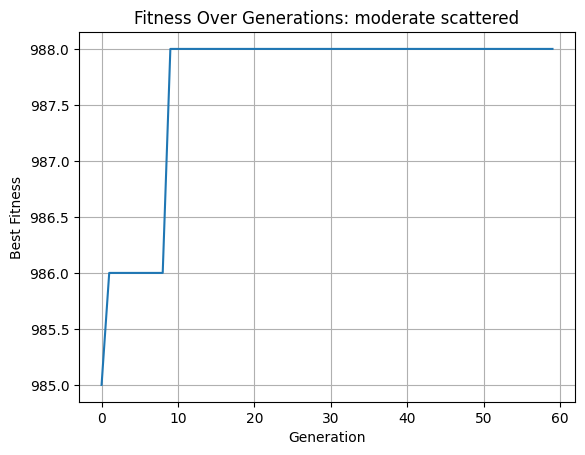

Best Path: [(1, 1), (2, 1), (3, 0), (4, 1), (5, 2), (6, 3), (6, 4), (7, 5), (8, 6), (7, 7), (8, 8), (9, 9)]
Obstacles: {(3, 7), (5, 4), (5, 1), (5, 7), (8, 0), (8, 3), (8, 9), (0, 2), (2, 2), (0, 8), (2, 5), (4, 2), (5, 6), (5, 3), (2, 7), (4, 7), (6, 0), (6, 6), (7, 8)}
Valid Path:
===== COMPLEX SCATTERED ENVIRONMENT =====


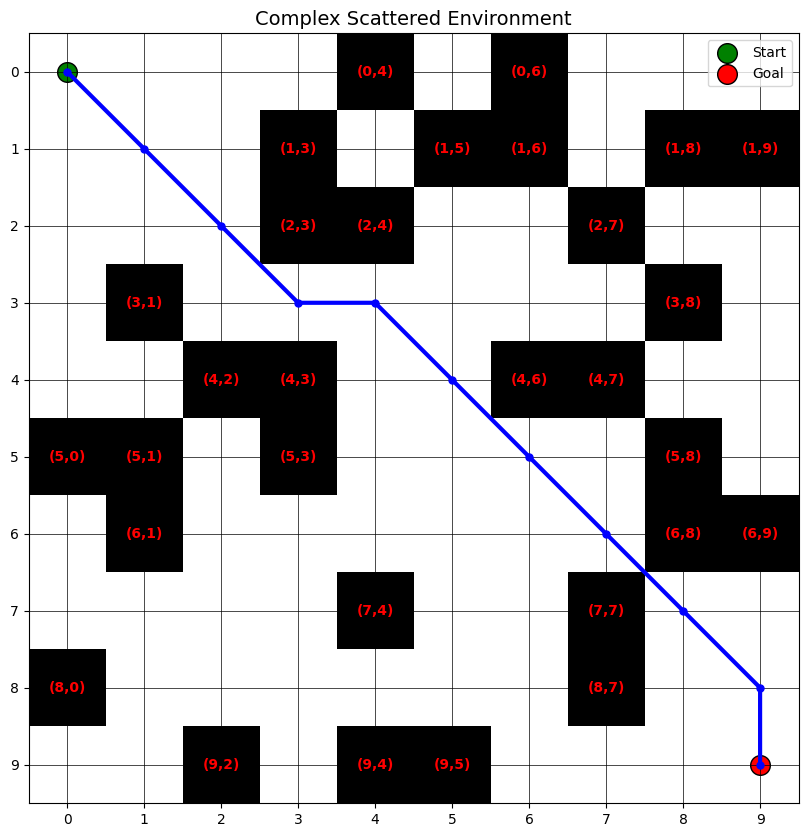

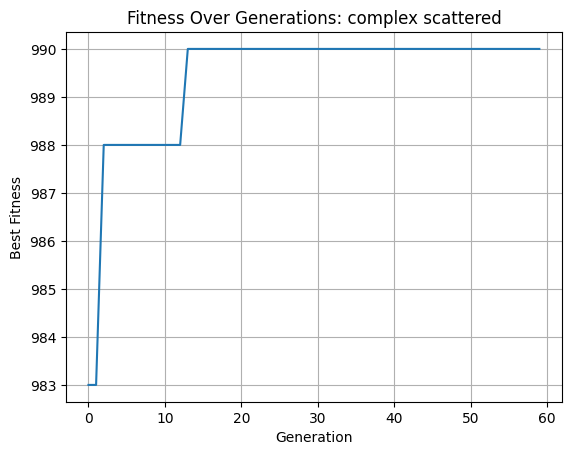

Best Path: [(1, 1), (2, 2), (3, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 9)]
Obstacles: {(4, 3), (3, 1), (4, 6), (9, 2), (5, 1), (8, 0), (9, 5), (1, 6), (1, 3), (1, 9), (7, 4), (7, 7), (6, 8), (4, 2), (5, 0), (5, 3), (9, 4), (2, 4), (0, 4), (2, 7), (1, 5), (6, 1), (1, 8), (4, 7), (3, 8), (5, 8), (8, 7), (0, 6), (2, 3), (6, 9)}
Valid Path:


In [7]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Constants
GRID_SIZE = 10
START = (0, 0)
GOAL = (9, 9)
POP_SIZE = 75
MUTATION_RATE = 0.2
ELITE_COUNT = 2
MOVES = [(1, 0), (-1, 0), (0, 1), (0, -1), (1, 1), (-1, -1), (1, -1), (-1, 1)]

# Fixed environments
def indoor_environment():
    obstacles = set()
    for x in range(GRID_SIZE):
        if x not in [1, 8]:
            obstacles.add((x, 3))
            obstacles.add((x, 6))
    for y in range(GRID_SIZE):
        if y not in [3, 6]:
            obstacles.add((1, y))
            obstacles.add((8, y))
    for cell in [(0, 3), (1, 5), (8, 4), (8, 5), (9, 6)]:
        obstacles.discard(cell)
    return obstacles

def moderate_environment():
    coords = [
        (3, 7), (5, 4), (5, 1), (8, 0), (5, 7), (8, 3), (8, 9),
        (0, 2), (2, 2), (0, 8), (2, 5), (4, 2), (5, 6), (5, 3),
        (2, 7), (4, 7), (6, 0), (6, 6), (7, 8)
    ]
    return set(coords)

def complex_environment():
    coords = [
        (4, 3), (3, 1), (4, 6), (5, 1), (9, 2), (8, 0), (9, 5),
        (1, 6), (1, 3), (1, 9), (7, 4), (7, 7), (6, 8), (4, 2),
        (5, 0), (5, 3), (9, 4), (2, 4), (0, 4), (2, 7), (1, 5),
        (6, 1), (1, 8), (4, 7), (3, 8), (5, 8), (8, 7), (0, 6),
        (2, 3), (6, 9)
    ]
    return set(coords)

# Visualization
def visualize_grid(obstacles, path=None, title="Grid"):
    grid = np.zeros((GRID_SIZE, GRID_SIZE))
    for ox, oy in obstacles:
        grid[ox, oy] = 1

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(grid, cmap="gray_r", origin="upper")
    ax.set_xticks(np.arange(0, GRID_SIZE, 1))
    ax.set_yticks(np.arange(0, GRID_SIZE, 1))
    ax.set_xticklabels(np.arange(0, GRID_SIZE, 1))
    ax.set_yticklabels(np.arange(0, GRID_SIZE, 1))
    ax.grid(which="both", color="black", linestyle='-', linewidth=0.5)

    if path:
        ax.plot(*zip(*([(START[1], START[0])] + [(p[1], p[0]) for p in path])), marker="o", color="blue", markersize=5, linestyle="-", linewidth=3)

    for ox, oy in obstacles:
        ax.text(oy, ox, f"({ox},{oy})", ha='center', va='center', color='red', fontsize=10, fontweight='bold')

    ax.scatter(*START, color="green", label="Start", s=200, edgecolors="black")
    ax.scatter(*GOAL, color="red", label="Goal", s=200, edgecolors="black")
    ax.set_title(title, fontsize=14)
    ax.legend()
    plt.show()

# Path generation and GA
def generate_path(obstacles, greedy_prob=0.1):
    path = []
    pos = START
    visited = set([pos])
    for _ in range(30):
        valid_moves = [(m[0] + pos[0], m[1] + pos[1]) for m in MOVES if
                       0 <= m[0] + pos[0] < GRID_SIZE and
                       0 <= m[1] + pos[1] < GRID_SIZE and
                       (m[0] + pos[0], m[1] + pos[1]) not in obstacles and
                       (m[0] + pos[0], m[1] + pos[1]) not in visited]
        if not valid_moves or pos == GOAL:
            break
        if random.random() < greedy_prob:
            move = min(valid_moves, key=lambda p: np.linalg.norm(np.array(p) - np.array(GOAL)))
        else:
            move = random.choice(valid_moves)
        pos = move
        path.append(pos)
        visited.add(pos)
    return path

def fitness(path, obstacles):
    pos = START
    length = len(path)
    reached_goal = False
    visited = set([pos])
    backtracks = 0

    for next_pos in path:
        if next_pos in obstacles or not (0 <= next_pos[0] < GRID_SIZE and 0 <= next_pos[1] < GRID_SIZE):
            return -500
        if next_pos in visited:
            backtracks += 1
        visited.add(next_pos)
        pos = next_pos
        if pos == GOAL:
            reached_goal = True
            break

    distance_to_goal = np.linalg.norm(np.array(pos) - np.array(GOAL))

    if reached_goal:
        return 1000 - int(length + backtracks * 2)
    else:
        return -int(distance_to_goal * 10 + length + backtracks * 2)

def crossover(parent1, parent2):
    if len(parent1) < 2 or len(parent2) < 2:
        return parent1[:]
    a = random.randint(0, min(len(parent1), len(parent2)) - 2)
    b = random.randint(a + 1, min(len(parent1), len(parent2)) - 1)
    child = parent1[:a] + parent2[a:b] + parent1[b:]

    # Repair to ensure all steps are adjacent
    repaired = []
    pos = START
    for step in child:
        if abs(step[0] - pos[0]) <= 1 and abs(step[1] - pos[1]) <= 1:
            repaired.append(step)
            pos = step
        else:
            break
    return repaired

def mutate(path, obstacles):
    if path and random.random() < MUTATION_RATE:
        idx = random.randint(0, len(path) - 1)
        tail = generate_path(obstacles, greedy_prob=0.3)
        path = path[:idx] + tail
        if random.random() < 0.5:  # occasional extra mutation
            idx = random.randint(0, len(path) - 1)
            valid_moves = [(m[0] + path[idx][0], m[1] + path[idx][1]) for m in MOVES if
                           0 <= m[0] + path[idx][0] < GRID_SIZE and
                           0 <= m[1] + path[idx][1] < GRID_SIZE and
                           (m[0] + path[idx][0], m[1] + path[idx][1]) not in obstacles]
            if valid_moves:
                path[idx] = random.choice(valid_moves)
    return path

def select(population, obstacles):
    sorted_pop = sorted(population, key=lambda p: fitness(p, obstacles), reverse=True)
    ranks = list(range(len(population), 0, -1))
    return random.choices(sorted_pop, weights=ranks, k=1)[0]

def run_ga(environment_name, obstacle_generator, gens=60):
    print(f"===== {environment_name.upper()} ENVIRONMENT =====")
    obstacles = obstacle_generator()
    population = [generate_path(obstacles) for _ in range(POP_SIZE)]
    best_path = None
    max_fitnesses = []

    for _ in range(gens):
        population = sorted(population, key=lambda p: fitness(p, obstacles), reverse=True)
        new_population = population[:ELITE_COUNT]
        while len(new_population) < POP_SIZE:
            parent1, parent2 = select(population, obstacles), select(population, obstacles)
            child = crossover(parent1, parent2)
            child = mutate(child, obstacles)
            new_population.append(child)
        population = new_population
        best_path = population[0]
        max_fitnesses.append(fitness(best_path, obstacles))

    visualize_grid(obstacles, best_path, f"{environment_name.title()} Environment")
    plt.figure()
    plt.plot(max_fitnesses)
    plt.title(f'Fitness Over Generations: {environment_name}')
    plt.xlabel('Generation')
    plt.ylabel('Best Fitness')
    plt.grid(True)
    plt.show()

    print("Best Path:", best_path)
    print("Obstacles:", obstacles)
    print("Valid Path:" if all(pos not in obstacles for pos in best_path) else "Path Contains Obstacles")

# Run for all three environments
run_ga("indoor-like", indoor_environment)
run_ga("moderate scattered", moderate_environment)
run_ga("complex scattered", complex_environment)
